Using device: cuda
Files already downloaded and verified
CIFAR-10 dataset size: 50000
MNIST dataset size: 60000
CIFAR-10 dataset size: 1000
MNIST dataset size: 1000
Data loaders created.


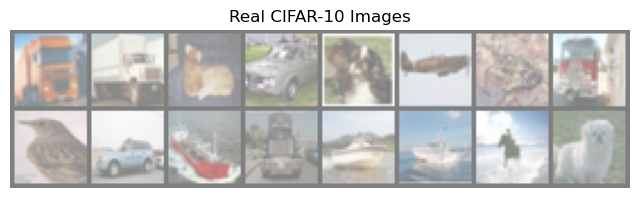

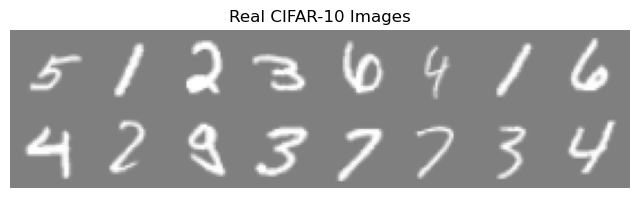

In [6]:
# Complete cDCGAN Implementation

# 1. Setup and Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 2. Define Hyperparameters
batch_size = 128
image_size = 32
nz = 100
num_epochs = 100
lr = 0.0002
beta1 = 0.5
num_classes = 10
embedding_dim = 50
sample_interval = 10
manualSeed = 999
torch.manual_seed(manualSeed)

# 3. Data Preparation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load MNIST dataset
mnist_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=mnist_transform
)

print(f'CIFAR-10 dataset size: {len(cifar10_dataset)}')
print(f'MNIST dataset size: {len(mnist_dataset)}')

# Function to create a subset (for testing)
def create_subset(dataset, subset_size=10000):
    indices = list(range(subset_size))
    return Subset(dataset, indices)

# Uncomment the following lines for testing with a subset
cifar10_dataset = create_subset(cifar10_dataset, subset_size=1000)
mnist_dataset = create_subset(mnist_dataset, subset_size=1000)

# Get me the size of the datasets
print(f'CIFAR-10 dataset size: {len(cifar10_dataset)}')
print(f'MNIST dataset size: {len(mnist_dataset)}')

# Use full datasets
cifar10_loader = DataLoader(
    cifar10_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

# mnist_loader = DataLoader(
#     mnist_subset, 
#     batch_size=batch_size, 
#     shuffle=True, 
#     num_workers=2
# )

# To use the full MNIST dataset, comment out the above mnist_subset lines and use the following:
mnist_loader = DataLoader(
    mnist_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

print('Data loaders created.')

# Visualization of a Batch of CIFAR-10 Images
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

real_batch = next(iter(cifar10_loader))
real_images, labels = real_batch
imshow(make_grid(real_images[:16], padding=2, normalize=True), title="Real CIFAR-10 Images")


real_batch = next(iter(mnist_loader))
real_images, labels = real_batch
imshow(make_grid(real_images[:16], padding=2, normalize=True), title="Real CIFAR-10 Images")



In [7]:
# 4. Model Design
class Generator(nn.Module):
    def __init__(self, nz, embedding_dim, num_classes, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(nz + embedding_dim, feature_g * 2 * self.init_size * self.init_size))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(feature_g * 2),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), -1, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_channels + 1, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        ds_size = image_size // 8
        self.adv_layer = nn.Sequential(
            nn.Linear(feature_d * 4 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.repeat(1, 1, image_size, image_size)
        d_in = torch.cat((img, label_embedding), 1)
        out = self.conv_blocks(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

# 5. Initialize Models, Loss Function, and Optimizers
generator = Generator(nz, embedding_dim, num_classes).to(device)
discriminator = Discriminator(num_classes, embedding_dim).to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

print('Generator and Discriminator initialized.')

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# 6. Training the cDCGAN
G_losses = []
D_losses = []
D_accuracies = []

print("Starting Training...")

for epoch in range(1, num_epochs+1):
    G_running_loss = 0.0
    D_running_loss = 0.0
    D_correct = 0
    D_total = 0
    
    for i, (imgs, labels) in enumerate(tqdm(cifar10_loader, desc=f'Epoch {epoch}/{num_epochs}')):
        batch_size_i = imgs.size(0)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size_i, 1, device=device)
        fake = torch.zeros(batch_size_i, 1, device=device)
        
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Train Discriminator
        discriminator.zero_grad()
        
        # Real images
        output_real = discriminator(real_imgs, labels)
        loss_real = adversarial_loss(output_real, valid)
        D_correct += ((output_real > 0.5).float() == valid).sum().item()
        D_total += batch_size_i
        
        # Sample noise and labels
        z = torch.randn(batch_size_i, nz, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_i,), device=device)
        
        # Generate fake images
        gen_imgs = generator(z, gen_labels)
        
        # Fake images
        output_fake = discriminator(gen_imgs.detach(), gen_labels)
        loss_fake = adversarial_loss(output_fake, fake)
        D_correct += ((output_fake < 0.5).float() == fake).sum().item()
        D_total += batch_size_i
        
        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()
        
        # Train Generator
        generator.zero_grad()
        
        output = discriminator(gen_imgs, gen_labels)
        loss_G = adversarial_loss(output, valid)
        loss_G.backward()
        optimizer_G.step()
        
        # Accumulate losses
        G_running_loss += loss_G.item()
        D_running_loss += loss_D.item()
    
    # Average losses and accuracy
    avg_G_loss = G_running_loss / len(cifar10_loader)
    avg_D_loss = D_running_loss / len(cifar10_loader)
    D_accuracy = D_correct / D_total * 100
    
    G_losses.append(avg_G_loss)
    D_losses.append(avg_D_loss)
    D_accuracies.append(D_accuracy)
    
    print(f'Epoch [{epoch}/{num_epochs}] | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f} | D Acc: {D_accuracy:.2f}%')
    
    # Save Images
    if epoch % sample_interval == 0 or epoch == 1:
        generator.eval()
        with torch.no_grad():
            sample_z = torch.randn(num_classes, nz, device=device)
            sample_labels = torch.arange(num_classes, device=device)
            generated_imgs = generator(sample_z, sample_labels)
            grid = make_grid(generated_imgs, nrow=5, normalize=True)
            plt.figure(figsize=(10,10))
            plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
            plt.title(f'Generated Images at Epoch {epoch}')
            plt.axis('off')
            plt.show()
        generator.train()




Generator and Discriminator initialized.
Starting Training...


Epoch 1/100:   0%|          | 0/8 [00:08<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 4, 4, 4], expected input[128, 53, 32, 32] to have 4 channels, but got 53 channels instead

In [ ]:
import subprocess
# Run Git commands to update the host
subprocess.run(["git", "add", "cDC_gan.ipynb"])
subprocess.run(["git", "commit", "-m", "Added cDCGAN implementation"])
# subprocess.run(["git", "push"])

CompletedProcess(args=['git', 'commit', '-m', 'Updated'], returncode=0)

In [ ]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(10,5))
plt.title("Discriminator Accuracy During Training")
plt.plot(D_accuracies, label="D Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# 7. Input-Output Generation Function
def generate_images(generator, label, num_images=1):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, nz, device=device)
        labels = torch.tensor([label]*num_images, device=device)
        gen_imgs = generator(z, labels)
        return gen_imgs

cifar10_classes = ['airplane','automobile','bird','cat','deer',
                  'dog','frog','horse','ship','truck']

# Example Usage
selected_label = 3  # 'cat'
generated = generate_images(generator, selected_label, num_images=16)
grid = make_grid(generated, nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.title(f'Generated Images for Label: {cifar10_classes[selected_label]}')
plt.axis('off')
plt.show()